In [ ]:
!pip install mitsuba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 23.4 MB/s eta 0:00:00


Mesh: 308802 triangles, total area = 24.00 m²


/tmp/ipython-input-2729614422.py:281: RuntimeWarning: invalid value encountered in scalar divide
  return np.where(np.abs(x) < 1e-12, 1.0, np.sin(x)/x)


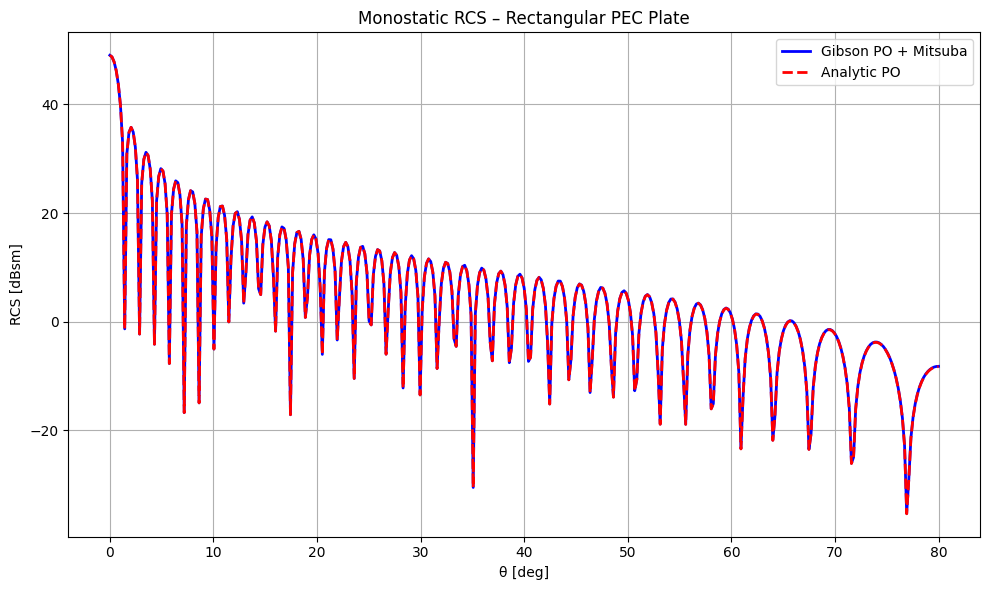

In [ ]:
import numpy as np
import mitsuba as mi
import matplotlib.pyplot as plt
import tempfile, io, os

# ============================================================
# Mitsuba setup
# ============================================================
mi.set_variant("cuda_ad_rgb")

# ============================================================
# Physical constants
# ============================================================
c0   = 299792458.0
freq = 1e9
lam  = c0 / freq
k0   = 2*np.pi / lam
eta0 = 376.730313668

# ============================================================
# Geometry: rectangular PEC plate
# ============================================================
L, W = 6.0, 4.0

# ============================================================
# λ-based mesh refinement
# ============================================================
def refined_rectangular_plate_mesh(L, W, lam, n_per_lambda=16):
    h = lam / n_per_lambda
    Nx = int(np.ceil(L / h))
    Ny = int(np.ceil(W / h))

    x = np.linspace(-L/2, L/2, Nx+1)
    y = np.linspace(-W/2, W/2, Ny+1)

    XX, YY = np.meshgrid(x, y, indexing="ij")
    verts = np.column_stack([XX.ravel(), YY.ravel(), np.zeros_like(XX).ravel()]).astype(np.float32)

    def vid(i, j):
        return i*(Ny+1) + j

    faces = []
    for i in range(Nx):
        for j in range(Ny):
            v0 = vid(i, j)
            v1 = vid(i+1, j)
            v2 = vid(i+1, j+1)
            v3 = vid(i, j+1)
            faces.append([v0, v1, v2])
            faces.append([v0, v2, v3])

    return verts, np.array(faces, dtype=np.int32)

verts, faces = refined_rectangular_plate_mesh(L, W, lam, n_per_lambda=24)

# ============================================================
# Triangle preprocessing (Gibson PO)
# ============================================================
T0 = verts[faces[:,0]]
T1 = verts[faces[:,1]]
T2 = verts[faces[:,2]]

centroids = (T0 + T1 + T2) / 3.0
normals = np.cross(T1 - T0, T2 - T0)
areas = 0.5 * np.linalg.norm(normals, axis=1)
normals /= np.linalg.norm(normals, axis=1, keepdims=True)

print(f"Mesh: {len(faces)} triangles, total area = {np.sum(areas):.2f} m²")

# ============================================================
# Write PLY + Mitsuba scene
# ============================================================
def write_ply(v, f):
    s = io.StringIO()
    s.write("ply\nformat ascii 1.0\n")
    s.write(f"element vertex {len(v)}\n")
    s.write("property float x\nproperty float y\nproperty float z\n")
    s.write(f"element face {len(f)}\n")
    s.write("property list uchar int vertex_indices\n")
    s.write("end_header\n")
    for x in v:
        s.write(f"{x[0]} {x[1]} {x[2]}\n")
    for t in f:
        s.write(f"3 {t[0]} {t[1]} {t[2]}\n")
    return s.getvalue()

with tempfile.NamedTemporaryFile(delete=False, suffix=".ply", mode="w") as f:
    f.write(write_ply(verts, faces))
    plyfile = f.name

scene = mi.load_dict({
    "type": "scene",
    "object": {
        "type": "ply",
        "filename": plyfile,
        "face_normals": True
    }
})

def pol_basis(k_hat):
    z_hat = np.array([0.0, 0.0, 1.0])
    if abs(np.dot(z_hat, k_hat)) > 0.999:
        z_hat = np.array([0.0, 1.0, 0.0])

    e_H = np.cross(z_hat, k_hat)
    e_H /= np.linalg.norm(e_H)

    e_V = np.cross(e_H, k_hat)
    e_V /= np.linalg.norm(e_V)

    return e_H, e_V
# ============================================================
# Polarization utility
# ============================================================
def transverse_pol(k):
    ref = np.array([0,0,1])
    if abs(np.dot(ref,k)) > 0.9:
        ref = np.array([0,1,0])
    e = np.cross(k, ref)
    return e / np.linalg.norm(e)

# ============================================================
# Mitsuba illumination test (centroid rays)
# ============================================================
def mitsuba_illumination_mask(centroids, k_hat, scene):
    origin_offset = 5 * lam
    origins = centroids - origin_offset * k_hat[None, :]
    directions = np.repeat(k_hat[None, :], len(centroids), axis=0)

    rays = mi.Ray3f(
        mi.Point3f(
            mi.Float(origins[:,0]),
            mi.Float(origins[:,1]),
            mi.Float(origins[:,2])
        ),
        mi.Vector3f(
            mi.Float(directions[:,0]),
            mi.Float(directions[:,1]),
            mi.Float(directions[:,2])
        )
    )

    its = scene.ray_intersect(rays)
    hit = its.is_valid()

    hit_p = np.column_stack([
        np.array(its.p.x),
        np.array(its.p.y),
        np.array(its.p.z)
    ])

    dist = np.linalg.norm(hit_p - centroids, axis=1)
    return hit & (dist < 1e-3)

# ============================================================
# Gibson PO surface current (PEC)
# ============================================================
def gibson_surface_current_PEC(centroids, normals, k_hat, E0):
    H0 = np.cross(k_hat, E0) / eta0
    phase = np.exp(-1j * k0 * (centroids @ k_hat))
    Js = 2.0 * np.cross(normals, H0[None,:]) * phase[:,None]
    return Js

# ============================================================
# Gibson far-field integration
# ============================================================
def gibson_far_field(centroids, Js, areas, r_hat):
    phase = np.exp(1j * k0 * (centroids @ r_hat))
    integrand = np.cross(r_hat[None,:], np.cross(r_hat[None,:], Js))
    E = np.sum(integrand * phase[:,None] * areas[:,None], axis=0)
    return (1j * k0 * eta0 / (4*np.pi)) * E

# ============================================================
# Monostatic RCS (Gibson + Mitsuba)
# ============================================================
def gibson_po_rcs(theta, phi, pol="HH"):
    k_hat = np.array([
        np.sin(theta)*np.cos(phi),
        np.sin(theta)*np.sin(phi),
       -np.cos(theta)
    ])

    e_H, e_V = pol_basis(k_hat)

    if pol == "HH":
        E_inc = e_H
        E_rec = e_H
    elif pol == "VV":
        E_inc = e_V
        E_rec = e_V
    elif pol == "HV":
        E_inc = e_H
        E_rec = e_V
    elif pol == "VH":
        E_inc = e_V
        E_rec = e_H
    else:
        raise ValueError("Invalid polarization")

    r_hat = -k_hat
    #E0 = transverse_pol(k_hat)

    illum = mitsuba_illumination_mask(centroids, k_hat, scene)
    if not np.any(illum):
        return -300.0

    #Js = gibson_surface_current_PEC(
    #    centroids[illum],
    #    normals[illum],
    #    k_hat,
    #    E0
    #)
    Js = gibson_surface_current_PEC(
        centroids[illum],
        normals[illum],
        k_hat,
        E_inc
    )


    E_scat = gibson_far_field(
        centroids[illum],
        Js,
        areas[illum],
        r_hat
    )

    E_proj = np.dot(E_scat, E_rec)
    sigma = 4*np.pi*np.abs(E_proj)**2
    return 10*np.log10(sigma + 1e-30)


    #sigma = 4*np.pi*np.linalg.norm(E_scat)**2
    #return 10*np.log10(sigma + 1e-30)

# ============================================================
# Analytic PO RCS (rectangular plate)
# ============================================================
def analytic_po_rcs_pol(theta, phi, L, W, lam, pol="HH"):
    k = 2*np.pi / lam

    k_hat = np.array([
        np.sin(theta)*np.cos(phi),
        np.sin(theta)*np.sin(phi),
       -np.cos(theta)
    ])

    r_hat = -k_hat

    e_H, e_V = pol_basis(k_hat)

    if pol == "HH":
        e_tx, e_rx = e_H, e_H
    elif pol == "VV":
        e_tx, e_rx = e_V, e_V
    elif pol == "HV":
        e_tx, e_rx = e_H, e_V
    elif pol == "VH":
        e_tx, e_rx = e_V, e_H
    else:
        raise ValueError("Invalid polarization")

    # Flat plate normal
    n_hat = np.array([0.0, 0.0, 1.0])

    # PO current direction (up to constants)
    H_inc = np.cross(k_hat, e_tx)
    J = np.cross(n_hat, H_inc)

    # Radiation operator
    F = np.cross(r_hat, np.cross(r_hat, J))

    # Polarization projection
    pol_factor = np.dot(e_rx, F)

    # Spatial Fourier transform (sinc terms)
    u = k * L * np.sin(theta) * np.cos(phi)
    v = k * W * np.sin(theta) * np.sin(phi)

    def sinc(x):
        return np.where(np.abs(x) < 1e-12, 1.0, np.sin(x)/x)

    aperture = L * W * sinc(u) * sinc(v)

    sigma = (4*np.pi/lam**2) * np.abs(pol_factor)**2 * aperture**2
    return 10*np.log10(sigma + 1e-30)

# ============================================================
# θ-cut validation
# ============================================================
phi = np.deg2rad(0.0)
thetas = np.deg2rad(np.linspace(0, 80, 391))

pol = "VV"

rcs_num = np.array([gibson_po_rcs(t, phi, pol) for t in thetas])
rcs_ana = np.array([analytic_po_rcs_pol(t, phi, L, W, lam, pol) for t in thetas])

plt.figure(figsize=(10,6))
plt.plot(np.rad2deg(thetas), rcs_num, 'b', lw=2, label="Gibson PO + Mitsuba")
plt.plot(np.rad2deg(thetas), rcs_ana, 'r--', lw=2, label="Analytic PO")
plt.xlabel("θ [deg]")
plt.ylabel("RCS [dBsm]")
plt.title("Monostatic RCS – Rectangular PEC Plate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

os.unlink(plyfile)
